### 1. Výpočet tepové frekvence z EKG signálu

In [1]:
import wfdb
from wfdb import Record, Annotation
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import os
import pywt
from typing import List, Tuple

In [2]:
plt.style.use("dark_background")

In [3]:
# Vstupní data: https://physionet.org/content/butqdb/1.0.0/
# Testovací databáze: https://physionet.org/content/nsrdb/1.0.0/

In [4]:
def ecg_info(ecg: Record) -> None:
    info = [
        ["Název souboru", ecg.record_name],
        ["Vzorkovací frekvence (Hz)", ecg.fs],
        ["Délka signálu (vzorky)", ecg.sig_len],
        ["Počet kanálů", ecg.n_sig],
        ["Názvy kanálů", ", ".join(ecg.sig_name)],
        ["Jednotky pro každý kanál", ", ".join(ecg.units)],
    ]
    info_df = pd.DataFrame(info, columns=["Informace", "Hodnota"])
    display(info_df)

In [5]:
ecg: Record = wfdb.rdrecord("data/100001/100001_ECG")
ecg_info(ecg)

,Informace,Hodnota
0,Název souboru,100001_ECG
1,Vzorkovací frekvence (Hz),1000
2,Délka signálu (vzorky),87087000
3,Počet kanálů,1
4,Názvy kanálů,ECG
5,Jednotky pro každý kanál,uV


,Informace,Hodnota
0,Název souboru,100001_ACC
1,Vzorkovací frekvence (Hz),100
2,Délka signálu (vzorky),8708700
3,Počet kanálů,3
4,Názvy kanálů,"ACCx, ACCy, ACCz"
5,Jednotky pro každý kanál,"mg, mg, mg"


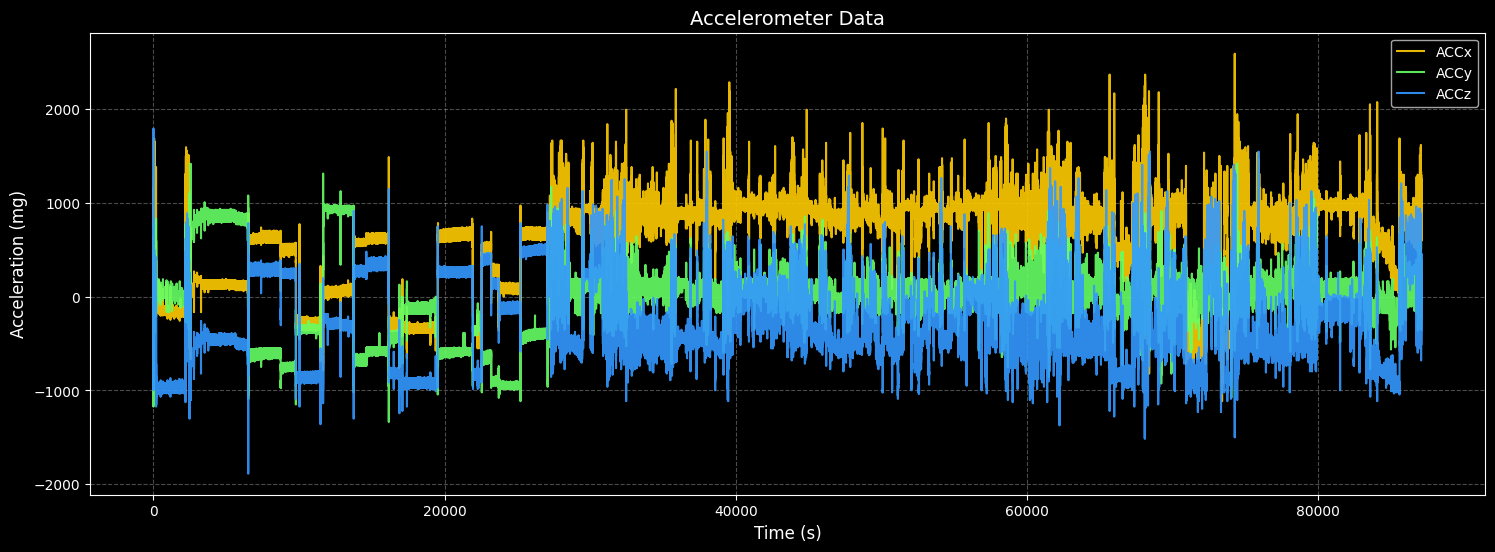

In [6]:
acc: Record = wfdb.rdrecord("data/100001/100001_ACC")
ecg_info(acc)

time_axis = np.arange(acc.sig_len) / acc.fs
acc_x = acc.p_signal[:, 0]  # ACCx
acc_y = acc.p_signal[:, 1]  # ACCy
acc_z = acc.p_signal[:, 2]  # ACCz

plt.figure(figsize=(18, 6))
plt.plot(time_axis, acc_x, label="ACCx", color="#ffcc00", alpha=0.9, linewidth=1.5)
plt.plot(time_axis, acc_y, label="ACCy", color="#66ff66", alpha=0.9, linewidth=1.5)
plt.plot(time_axis, acc_z, label="ACCz", color="#3399ff", alpha=0.9, linewidth=1.5)
plt.title("Accelerometer Data", fontsize=14)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Acceleration (mg)", fontsize=12)
plt.legend()
plt.grid(which="both", linestyle="--", alpha=0.3)
plt.show()

In [7]:
class PanTompkinsDetector:
    def __init__(self, ecg_signal: np.ndarray, fs: float):
        self.fs = fs
        self.ecg_signal = ecg_signal

    def _center_signal(self, signal: np.ndarray) -> np.ndarray:
        return signal - np.mean(signal)

    def _bandpass_filter(
        self, signal: np.ndarray, lowcut_hz=5, highcut_hz=15, order=2
    ) -> np.ndarray:
        nyquist_freq = 0.5 * self.fs
        low = lowcut_hz / nyquist_freq
        high = highcut_hz / nyquist_freq
        b, a = butter(order, [low, high], btype="band")
        return filtfilt(b, a, signal)

    def _derivative_filter(self, signal: np.ndarray) -> np.ndarray:
        # Diferenční rovnice derivátoru podle Pan-Tompkins:
        # y(n) = (1/8) * [2*x(n) + x(n-1) - x(n-3) - 2*x(n-4)]
        kernel = np.array([2, 1, 0, -1, -2]) / 8.0
        return np.convolve(signal, kernel, mode="same")

    def _squaring(self, signal: np.ndarray) -> np.ndarray:
        return np.power(signal, 2)

    def _moving_window_integration(
        self, signal: np.ndarray, window_ms=150
    ) -> np.ndarray:
        MS_IN_SECOND = 1000.0
        window_size = int(self.fs * (window_ms / MS_IN_SECOND))
        kernel = np.ones(window_size) / window_size
        return np.convolve(signal, kernel, mode="same")

    def _detect_r_peaks(self, signal_integrated: np.ndarray) -> np.ndarray:
        DISTANCE_SECONDS = 0.2
        HEIGHT_RATIO = 0.3
        min_distance = int(DISTANCE_SECONDS * self.fs)
        height_threshold = HEIGHT_RATIO * np.max(signal_integrated)
        peaks, _ = find_peaks(
            signal_integrated, distance=min_distance, height=height_threshold
        )
        return peaks

    def _calculate_bpm(self, r_peaks_indices: np.ndarray) -> float:
        SECONDS_PER_MINUTE = 60.0
        signal_length_seconds = len(self.ecg_signal) / self.fs
        bpm = (len(r_peaks_indices) / signal_length_seconds) * SECONDS_PER_MINUTE
        return bpm

    def _plot_signal(self, title: str, signal: np.ndarray):
        time_axis = np.arange(len(signal)) / self.fs
        plt.figure(figsize=(18, 5))
        plt.title(title)
        plt.plot(time_axis, signal, label=title, color="cyan")
        plt.xlabel("Čas [s]")
        plt.ylabel("Amplituda [µV]")
        plt.grid(which="both", linestyle="--", alpha=0.2)
        plt.show()

    def _plot_detected_r_peaks(
        self, signal_integrated: np.ndarray, r_peaks_indices: np.ndarray
    ):
        time_axis = np.arange(len(signal_integrated)) / self.fs
        r_peaks_times = r_peaks_indices / self.fs
        plt.figure(figsize=(18, 5))
        plt.title("Detekované R-peaky na integrovaném signálu")
        plt.plot(time_axis, signal_integrated, label="Integrovaný signál", color="cyan")
        plt.plot(
            r_peaks_times,
            signal_integrated[r_peaks_indices],
            "rx",
            label="R-peaks",
        )
        plt.xlabel("Čas [s]")
        plt.ylabel("Amplituda [µV]")
        plt.grid(which="both", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()

    def _plot_heart_rate(self, r_peaks_indices: np.ndarray):
        rr_intervals = np.diff(r_peaks_indices) / self.fs
        bpm_values = 60 / rr_intervals
        time_bpm = r_peaks_indices[1:] / self.fs
        plt.figure(figsize=(18, 5))
        plt.plot(time_bpm, bpm_values, marker="o", label="Tepová frekvence (BPM)")
        plt.title("Tepová frekvence v závislosti na čase")
        plt.xlabel("Čas [s]")
        plt.ylabel("Tepová frekvence [BPM]")
        plt.grid(which="both", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()

    def solve(self, plot_graphs=True):
        """
        Spustí celý Pan-Tompkins řetězec:
        1) Centralizace signálu okolo vodorovné osy
        2) Band-pass filtr
        3) Derivační filtr
        4) Umocnění na druhou
        5) Posuvné integrační okno
        6) Detekce R-peaks + výpočet tepové frekvence
        """
        signal_centered = self._center_signal(self.ecg_signal)
        signal_bandpass = self._bandpass_filter(signal_centered)
        signal_derivative = self._derivative_filter(signal_bandpass)
        signal_squared = self._squaring(signal_derivative)
        signal_integrated = self._moving_window_integration(signal_squared)

        r_peaks_indices = self._detect_r_peaks(signal_integrated)
        bpm = self._calculate_bpm(r_peaks_indices)

        if plot_graphs:
            self._plot_signal("1) Signál po centralizaci", signal_centered)
            self._plot_signal("2) Signál po band-pass filtru", signal_bandpass)
            self._plot_signal("4) Signál po derivačním filtru", signal_derivative)
            self._plot_signal("5) Signál po umocnění", signal_squared)
            self._plot_signal(
                "6) Signál po posuvném integračním oknu", signal_integrated
            )
            self._plot_detected_r_peaks(signal_integrated, r_peaks_indices)
            self._plot_heart_rate(r_peaks_indices)

        return {
            "centered": signal_centered,
            "bandpass": signal_bandpass,
            "derivative": signal_derivative,
            "squared": signal_squared,
            "integrated": signal_integrated,
            "r_peaks_indices": r_peaks_indices,
            "heart_rate_bpm": bpm,
        }

In [8]:
ecg_100001: Record = wfdb.rdrecord(
    "data/100001/100001_ECG", sampfrom=40000, sampto=60000
)

ecg_signal: np.ndarray = ecg_100001.p_signal.squeeze()
fs: float = ecg_100001.fs

detector = PanTompkinsDetector(ecg_signal, fs)
results = detector.solve(plot_graphs=False)

print(f"Počet detekovaných R-peaků: {len(results['r_peaks_indices'])}")
print(f"Odhadovaná tepová frekvence (BPM): {results['heart_rate_bpm']}")

Počet detekovaných R-peaků: 34
Odhadovaná tepová frekvence (BPM): 102.0


In [9]:
ecg: Record = wfdb.rdrecord("test_data/16265")
ecg_info(ecg)

,Informace,Hodnota
0,Název souboru,16265
1,Vzorkovací frekvence (Hz),128
2,Délka signálu (vzorky),11730944
3,Počet kanálů,2
4,Názvy kanálů,"ECG1, ECG2"
5,Jednotky pro každý kanál,"mV, mV"


In [10]:
def evaluate(path: str, sampfrom=0, sampto=1400, tolerance=0.035):
    ecg: Record = wfdb.rdrecord(path, sampfrom=sampfrom, sampto=sampto)
    annotations: Annotation = wfdb.rdann(path, "atr", sampfrom=sampfrom, sampto=sampto)
    signal = ecg.p_signal[:, 0]
    fs = ecg.fs

    detector = PanTompkinsDetector(signal, fs)
    results = detector.solve(plot_graphs=False)

    detected_peaks = results["r_peaks_indices"]
    annotated_peaks = annotations.sample

    tolerance_samples = int(tolerance * fs)

    correctly_detected = 0
    for annotated_peak in annotated_peaks:
        if any(
            abs(annotated_peak - detected_peak) <= tolerance_samples
            for detected_peak in detected_peaks
        ):
            correctly_detected += 1
    wrongly_detected = len(detected_peaks) - correctly_detected

    return (
        correctly_detected,
        wrongly_detected,
        len(annotated_peaks),
        len(detected_peaks),
    )


sampfrom = 0
sampto = 1400
folder = "test_data"
data = []

for file in os.listdir(folder):
    if file.endswith(".dat"):
        file_path = os.path.join(folder, file[:-4])
        correct, wrong, annotated, detected = evaluate(
            file_path, sampfrom=sampfrom, sampto=sampto
        )
        success_rate = (correct / annotated * 100) if annotated > 0 else 0
        data.append([file[:-4], correct, wrong, annotated, round(success_rate, 2)])

print("Detekce R vrcholů")
df = pd.DataFrame(
    data,
    columns=[
        "Soubor",
        "Správně",
        "Špatně",
        "Anotovány",
        "Úspěšnost (%)",
    ],
)
print(df)

total_correct = df["Správně"].sum()
total_annotated = df["Anotovány"].sum()
overall_success_rate = total_correct / total_annotated * 100
print(f"Celková úspěšnost: {overall_success_rate:.2f}%")

Detekce R vrcholů
   Soubor  Správně  Špatně  Anotovány  Úspěšnost (%)
0   16265       17       0         18          94.44
1   16272       11       0         12          91.67
2   16273       18       0         18         100.00
3   16420       17       0         17         100.00
4   16483       18       0         18         100.00
5   16539       14       0         14         100.00
6   16773       13       0         28          46.43
7   16786       13       0         14          92.86
8   16795        5       7         24          20.83
9   17052       12       0         12         100.00
10  17453       14       0         15          93.33
11  18177       20       0         20         100.00
12  18184       14       0         16          87.50
13  19088       22       0         23          95.65
14  19090       22       0         22         100.00
15  19093       21       0         22          95.45
16  19140       22       0         22         100.00
17  19830       22       0  

### 2. Výpočet tepové frekvence z EKG signálu

Detected 17 anomaly segments.


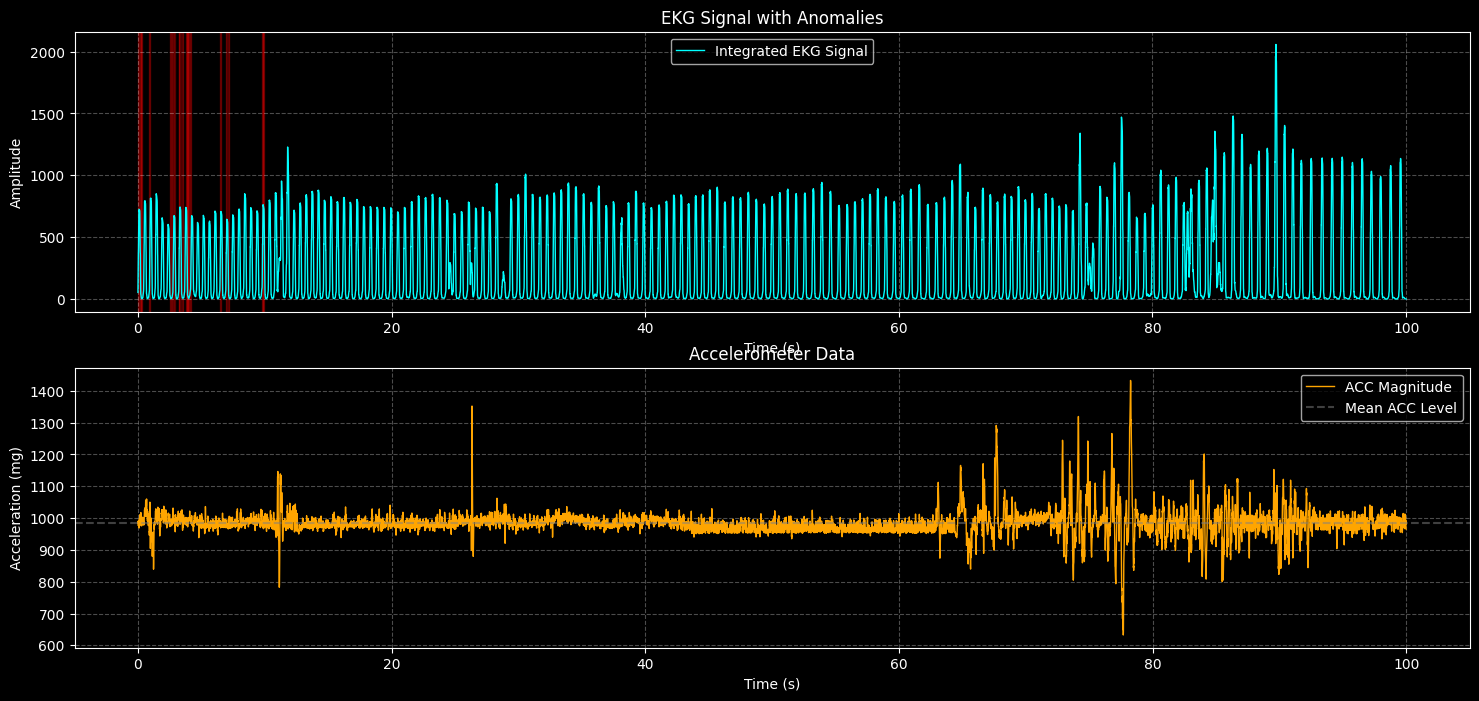

In [11]:
class ECGAnomalyDetector:
    def __init__(
        self,
        ecg_signal: np.ndarray,
        acc_signal: np.ndarray,
        fs_ecg: float,
        fs_acc: float,
    ):
        self.ecg_signal = ecg_signal
        self.acc_signal = acc_signal
        self.fs_ecg = fs_ecg
        self.fs_acc = fs_acc

    def _wavelet_transform(
        self, signal: np.ndarray, wavelet_name: str = "db4", level: int = 4
    ) -> np.ndarray:
        coeffs = pywt.wavedec(signal, wavelet_name, level=level)
        return pywt.waverec(coeffs[:-1], wavelet_name)

    def detect_anomalies(
        self, percentile_threshold: float = 90, min_anomaly_duration: int = 50
    ) -> List[Tuple[int, int]]:
        denoised_ecg = self._wavelet_transform(self.ecg_signal)
        acc_energy = np.sum(np.square(self.acc_signal), axis=1)
        acc_energy = gaussian_filter1d(acc_energy, sigma=3)
        acc_energy = np.interp(
            np.linspace(0, len(denoised_ecg), len(denoised_ecg)),
            np.linspace(0, len(acc_energy), len(acc_energy)),
            acc_energy,
        )

        threshold = np.percentile(acc_energy, percentile_threshold)
        anomaly_mask = acc_energy > threshold

        segments = []
        in_segment = False
        start_idx = 0

        for i, is_anomalous in enumerate(anomaly_mask):
            if is_anomalous and not in_segment:
                in_segment = True
                start_idx = i
            elif not is_anomalous and in_segment:
                in_segment = False
                if (i - start_idx) >= min_anomaly_duration:
                    segments.append((start_idx, i))

        if in_segment and (len(anomaly_mask) - start_idx) >= min_anomaly_duration:
            segments.append((start_idx, len(anomaly_mask) - 1))

        return segments

    def plot_anomalies(self, anomalies: List[Tuple[int, int]]):
        time_ecg = np.arange(len(self.ecg_signal)) / self.fs_ecg
        time_acc = np.arange(len(self.acc_signal)) / self.fs_acc

        plt.figure(figsize=(18, 8))

        plt.subplot(2, 1, 1)
        plt.plot(
            time_ecg,
            self.ecg_signal,
            label="Integrated EKG Signal",
            color="cyan",
            linewidth=1,
        )
        for start, end in anomalies:
            plt.axvspan(time_ecg[start], time_ecg[end], color="red", alpha=0.3)
        plt.title("EKG Signal with Anomalies")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.3)

        plt.subplot(2, 1, 2)
        acc_magnitude = np.sqrt(
            np.sum(np.square(self.acc_signal), axis=1)
        )  # Výpočet celkové akcelerace
        plt.plot(
            time_acc, acc_magnitude, label="ACC Magnitude", color="orange", linewidth=1
        )
        plt.axhline(
            np.mean(acc_magnitude),
            color="gray",
            linestyle="--",
            alpha=0.5,
            label="Mean ACC Level",
        )
        plt.title("Accelerometer Data")
        plt.xlabel("Time (s)")
        plt.ylabel("Acceleration (mg)")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.3)

        plt.show()


# =============================
# Použití na konkrétním úseku
# =============================
record_ecg_path = "data/100001/100001_ECG"
record_acc_path = "data/100001/100001_ACC"

sampfrom = 100000
sampto = 200000

# Načtení EKG a ACC dat
ecg_record = wfdb.rdrecord(record_ecg_path, sampfrom=sampfrom, sampto=sampto)
acc_record = wfdb.rdrecord(
    record_acc_path, sampfrom=sampfrom // 10, sampto=sampto // 10
)  # Odpovídající vzorky pro ACC

# Extrakce signálů
ecg_signal = ecg_record.p_signal.squeeze()
acc_signal = acc_record.p_signal  # Tříkanálový ACC signál

# Použití Pan-Tompkins detektoru
pt_detector = PanTompkinsDetector(ecg_signal, ecg_record.fs)
results = pt_detector.solve(plot_graphs=False)  # Použití integrovaného signálu

# Použití detekce anomálií na INTEGROVANÝM signálu
detector = ECGAnomalyDetector(
    results["integrated"], acc_signal, ecg_record.fs, acc_record.fs
)
anomalies = detector.detect_anomalies()

# Výstup
print(f"Detected {len(anomalies)} anomaly segments.")
detector.plot_anomalies(anomalies)